First read the movies' synopsis and genre

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)

synopsis=pd.read_csv('data/plot_summaries.txt',header=None,delimiter='\t')

In [2]:
synopsis.columns=['id','text']
synopsis.head()

,id,text
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [3]:
movies_meta=pd.read_csv('data/movie.metadata.tsv',header=None,delimiter='\t')
movies_meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
movies_genre=movies_meta[[0,8]]
movies_genre.columns=['id','genres']
movies_genre['genres']=movies_genre['genres'].apply(eval).apply(lambda x: list(x.values()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
movies_genre.iloc[0]

id                                                   975900
genres    [Thriller, Science Fiction, Horror, Adventure,...
Name: 0, dtype: object

Join these 2 tables to get id-synopsis-genre

In [5]:
data=synopsis.set_index('id').join(movies_genre.set_index('id'))

In [6]:
data=data.dropna()
#data.to_csv('id-syn-genres.csv')

In [7]:
data.head()

,text,genres
id,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Drama, World cinema]"
31186339,The nation of Panem consists of a wealthy Capi...,"[Action/Adventure, Science Fiction, Action, Dr..."
20663735,Poovalli Induchoodan is sentenced for six yea...,"[Musical, Action, Drama, Bollywood]"
2231378,"The Lemon Drop Kid , a New York City swindler,...","[Screwball comedy, Comedy]"
595909,Seventh-day Adventist Church pastor Michael Ch...,"[Crime Fiction, Drama, Docudrama, World cinema..."


Preprocess data for text processing using Keras

Apply One hot encoder on the labels first

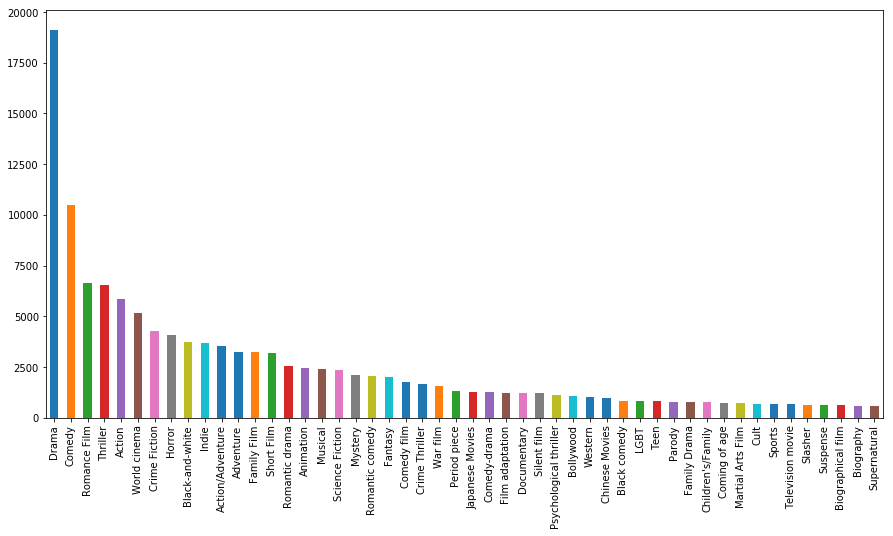

In [11]:
total_genres=[]

#flatten all genres
for movie in data['genres'].values:
    total_genres.extend(movie)

#There are many genres (363), to simplify the first run, let's shortlist only the top common genres
all_genres=pd.Series(total_genres)
genre_counts=all_genres.value_counts()
genre_counts[:50].plot(kind='bar')

all_genres=genre_counts.nlargest(50).index.tolist()

In [12]:
#Only take 50 top common genres
labels=(np.in1d(all_genres,data['genres'].values[0]))

for i in range(1,data['genres'].shape[0]):
    labels=np.vstack((labels,np.in1d(all_genres,data['genres'].values[i])))

labels=labels.astype(int)
labels.shape

(42204, 50)

# Preprocess the text

In [13]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(data['text'].values,labels)

vocab_size=10000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['text'].values)

X_train_tokenized=tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test_tokenized=tokenizer.texts_to_matrix(X_test,mode='tfidf')

Using TensorFlow backend.


In [14]:
model=Sequential()
#depth of 1
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))

#drop some nodes for regularization here
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 363 genres in total - too many think of reducing 
model.add(Dense(len(all_genres)))

#fully connected layer
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

out=model.fit(X_train_tokenized,y_train,epochs=5,verbose=1)

Epoch 1/5
31653/31653 [==============================] - 45s 1ms/step - loss: 8.9665 - acc: 0.4244
Epoch 2/5
31653/31653 [==============================] - 44s 1ms/step - loss: 7.4841 - acc: 0.4405
Epoch 3/5
31653/31653 [==============================] - 44s 1ms/step - loss: 6.7252 - acc: 0.4525
Epoch 4/5
31653/31653 [==============================] - 44s 1ms/step - loss: 6.3599 - acc: 0.4582
Epoch 5/5
31653/31653 [==============================] - 44s 1ms/step - loss: 6.0867 - acc: 0.4630


In [15]:
#Save the model first before proceeding
import pickle
model.save('movie_genre_5_epochs')
fp=open('tokenizer.pickle','wb')
pickle.dump(tokenizer,fp)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                25650     
__________

The accuracy converges after 3th epoch and it looks like it doesn't increase much afterwards. The accuracy is not so good. 

Potential problems to solve:
1. Too many classes in the labels?
2. The tuning of parameters?
3. Haven't dealt with unbalanced numbers of labels (much more actions movies than Screwball Comedy)
4. The labels are exclusive (total sum to 1). It is probably necessary to tune the model to do multi-label classification (a movie can belong to multiple genres)

Let's see how it predicts first, and confirm the $4^{th}$ point (synopsis taken from IMDB)

<BarContainer object of 3 artists>

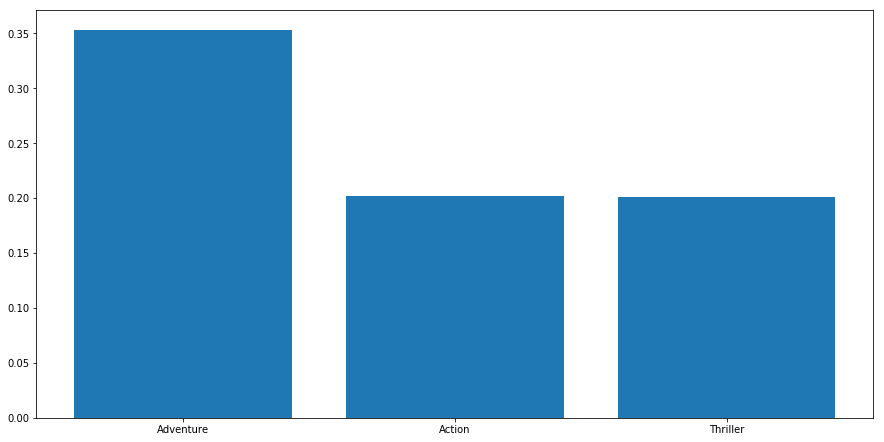

In [49]:
TOP_SCORES=3
# Mission Impossible
mission_impossible=open('data/to_predict/mission_impossible.txt').read()
m1_tokenized=tokenizer.texts_to_matrix(np.array([mission_impossible]),mode='tfidf')
m1_predicted=model.predict(m1_tokenized)
#See the top 3 predicted classification
genres_np=np.array(all_genres)
genres_txt=genres_np[np.ravel(m1_predicted).argsort()[-TOP_SCORES:]]
weight=np.sort(np.ravel(m1_predicted))[::-1][:TOP_SCORES]
plt.bar(np.arange(0,TOP_SCORES),weight,tick_label=genres_txt)

<BarContainer object of 3 artists>

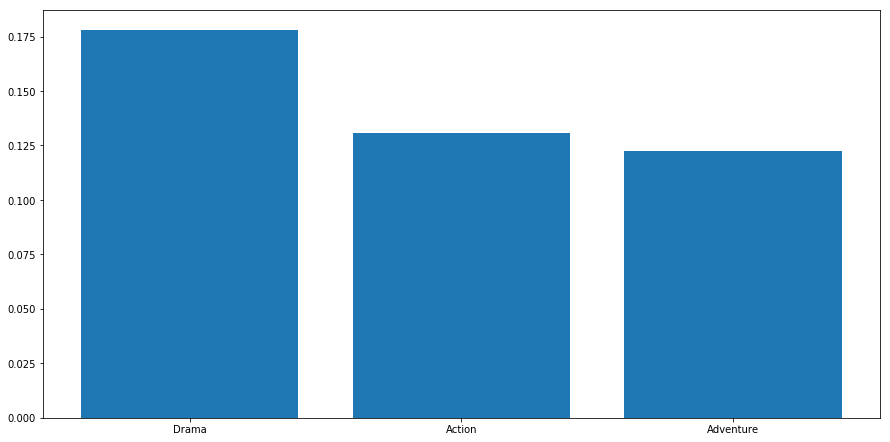

In [51]:
#Lord of the rings
lotr=open('data/to_predict/lotr.txt').read()
m2_tokenized=tokenizer.texts_to_matrix(np.array([lotr]),mode='tfidf')
m2_predicted=model.predict(m2_tokenized)

genres_txt=genres_np[np.ravel(m2_predicted).argsort()[-TOP_SCORES:]]
weight=np.sort(np.ravel(m2_predicted))[::-1][:TOP_SCORES]
plt.bar(np.arange(0,TOP_SCORES),weight,tick_label=genres_txt)

This confirms that the genres are exclusive. All predicted probabilities of a movie sum to 1. The model needs to be adjusted to do multi-label classification.

In [53]:
model_multi=Sequential()
#depth of 1
model_multi.add(Dense(512, input_shape=(vocab_size,)))
model_multi.add(Activation('relu'))

#drop some nodes for regularization here
model_multi.add(Dropout(0.25))

model_multi.add(Dense(512))
model_multi.add(Activation('relu'))
model_multi.add(Dropout(0.25))

# 50 genres in total
model_multi.add(Dense(len(all_genres)))

#fully connected layer
model_multi.add(Activation('sigmoid'))
model_multi.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

out=model_multi.fit(X_train_tokenized,y_train,epochs=5,verbose=1)

Epoch 1/5
31653/31653 [==============================] - 45s 1ms/step - loss: 0.1666 - acc: 0.9450
Epoch 2/5
31653/31653 [==============================] - 43s 1ms/step - loss: 0.1144 - acc: 0.9576
Epoch 3/5
31653/31653 [==============================] - 43s 1ms/step - loss: 0.0838 - acc: 0.9680
Epoch 4/5
31653/31653 [==============================] - 43s 1ms/step - loss: 0.0670 - acc: 0.9749
Epoch 5/5
31653/31653 [==============================] - 43s 1ms/step - loss: 0.0570 - acc: 0.9790
